### Based off of optimized.ipynb
##### Implements parallelization, graph execution, and fixed F(t-1) problem

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# Define da model

from keras import layers

INPUT_SIZE = 30
LEARNING_RATE = 0.001

input = layers.Input(shape=(INPUT_SIZE,))
x = layers.Dense(20, activation='relu')(input)
x = layers.Dense(10, activation='relu')(input)
x = layers.Dense(1, activation='tanh')(x)
F_model = keras.Model(inputs=input, outputs=x)
F_model.summary()

F_model.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE), loss='mse')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [3]:
# Following 2 functions take whole arrays, of shape (instances, size)

def gen_price_series(size=10000, k=3, a=0.9, instances=1):
    p_series = np.ndarray((instances, size,), dtype=np.float32)
    b_series = np.ndarray((instances, size,), dtype=np.float32)
    p_series[:, 0] = 0
    b_series[:, 0] = 0

    for i in range(1, size):
        p_series[:, i] =  p_series[:, i-1] + b_series[:, i-1] + k * np.random.normal(size=instances)
        b_series[:, i] = a * b_series[:, i-1] + np.random.normal(size=instances)

    # shape: (instances)
    R = np.max(p_series, axis=1) - np.min(p_series, axis=1)
    z_series = np.exp(p_series / np.repeat(R[:, np.newaxis], size, axis=1))

    return z_series

def calc_price_returns(zt):
    # returns the set rt, with the first element (0) being NaN
    rt = np.ndarray(zt.shape, dtype=np.float32)
    rt[:, 0] = np.nan
    rt[:, 1:] = zt[:, 1:] - zt[:, :-1]
    return rt



# Following 2 functions take slices of the arrays, of shape (instances,)

def calc_return(mu, rt, Ft_curr, Ft_prev, rft=tf.constant(0.0), delta=tf.constant(0.0)):
    '''Calculates the returns (Rt) on-line.'''

    return mu * (rft + Ft_prev * (rt - rft) - delta * tf.math.abs(Ft_curr - Ft_prev))

def calc_DSR(n, Rt, At_prev, Bt_prev):
    '''Calculates the differential Sharpe ratios (DSR, Dt) on-line.'''

    At_curr = At_prev + n * (Rt - At_prev)
    Bt_curr = Bt_prev + n * (tf.math.square(Rt) - Bt_prev)

    dDt_dRt = (Bt_prev - At_prev * Rt) / tf.math.pow((Bt_prev - tf.math.square(At_prev)), 1.5)

    return dDt_dRt, At_curr, Bt_curr


from math import prod
# Repeat grades of shape (instances,) to shape (instances,) + grad.shape
def reshape_grad(grad, shape):
    # takes a tf.Tensor grad of shape (instances,) and the target shape (variables)
    instances = grad.shape[0]
    total_elements = prod(shape)
    grad = tf.repeat(grad, int(total_elements / instances))
    grad = tf.reshape(grad, shape)
    
    return grad

In [4]:
# Simulate trading using the outputs of the model
# Takes SLICES of the arrays, of shape (instances,)

def test_performance(zt, Ft):
    # zt: (instances, size)
    # Ft: (instances, size)

    instances = zt.shape[0]
    size = zt.shape[1]
    Ft = np.sign(Ft)

    values = np.ones((instances, size))
    owned = np.zeros((instances,))
    money = np.ones((instances,))
    values[:, 0] = money

    values_ideal = np.ones((instances, size))
    owned_ideal = np.zeros((instances,))
    money_ideal = np.ones((instances,))
    values_ideal[:, 0] = money_ideal

    for t in range(INPUT_SIZE, size - 1):

        # Model Ft

        # buy if Ft 1, owned 0 --> owned 1
        # sell if Ft -1, owned 1 --> owned 0

        # hold if Ft 0, owned 0 or 1
        # hold if Ft 1, owned 1
        # hold if Ft -1, owned 0

        # model
        buy = np.clip(Ft[:, t] * (1 - owned), 0, 1) # 1 if BUY, 0 if not
        sell = np.clip(-Ft[:, t] * owned, 0, 1) # 1 if SELL, 0 if not
        decision = buy - sell # 1 if BUY, -1 if SELL, 0 if HOLD
        owned = np.clip(owned + decision, 0, 1)
        money -= decision * zt[:, t]
        values[:, t] = money + owned * zt[:, t]

        # ideal
        deltas_ideal = np.sign(zt[:, t + 1] - zt[:, t])
        buy_ideal = np.clip(deltas_ideal * (1 - owned_ideal), 0, 1)
        sell_ideal = np.clip(-deltas_ideal * owned_ideal, 0, 1)
        decision_ideal = buy_ideal - sell_ideal
        owned_ideal = np.clip(owned_ideal + decision_ideal, 0, 1)
        money_ideal -= decision_ideal * zt[:, t]
        values_ideal[:, t] = money_ideal + owned_ideal * zt[:, t]
    
    values[:, -1] = np.nan
    values_ideal[:, -1] = np.nan

    return (values[-1] / zt[-1], values_ideal[-1] / zt[-1]), (values, values_ideal)


In [5]:

@tf.function
def calc_grads(zt, rt, At, Bt, N, MU, F_model, F_prev,):
    '''
    zt: zt[:, t - INPUT_SIZE + 1:t + 1]
    rt: rt[:, t]
    At: At[:, t-1]
    Bt: Bt[:, t-1]
    '''

    INSTANCES = zt.shape[0]

    with tf.GradientTape(persistent=True) as tape:
        F_curr = tf.reshape(F_model(zt), (INSTANCES,))
        
        # calculate the gradient
        Rt = calc_return(MU, rt, F_curr, F_prev)
        dDt_dRt, At_new, Bt_new = calc_DSR(N, Rt, At, Bt)

    # calculate derivatives.
    dRt_dFcurr = tape.gradient(Rt, F_curr) # shape: (instances,)
    dRt_dFprev = tape.gradient(Rt, F_prev) # shape: (instances,)
    dF_dTheta = tape.jacobian(F_curr, F_model.trainable_variables) # shape: (instances, MODEL VAR SHAPE)

    return Rt, F_curr, At_new, Bt_new, dDt_dRt, dRt_dFcurr, dRt_dFprev, dF_dTheta

Episode:  0


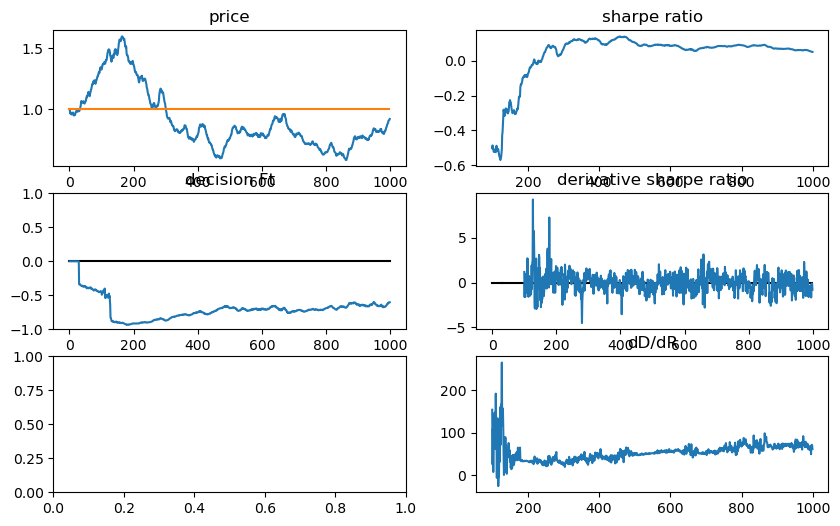

Episode:  1


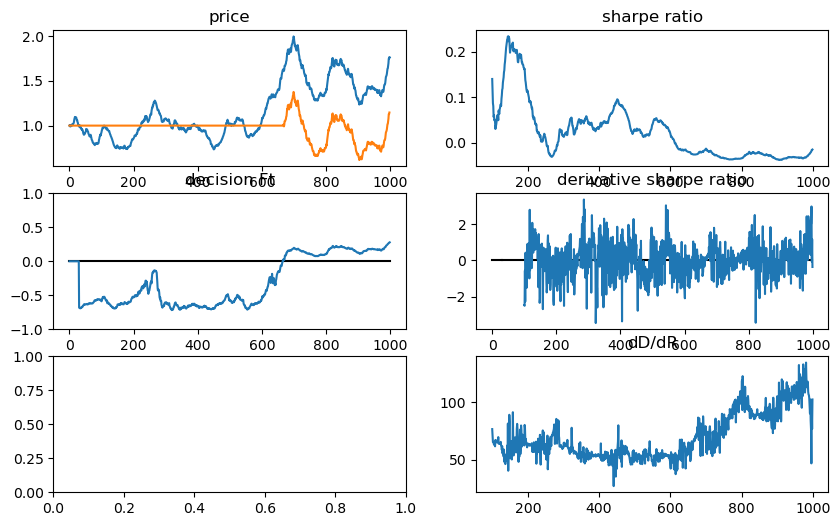

Episode:  2


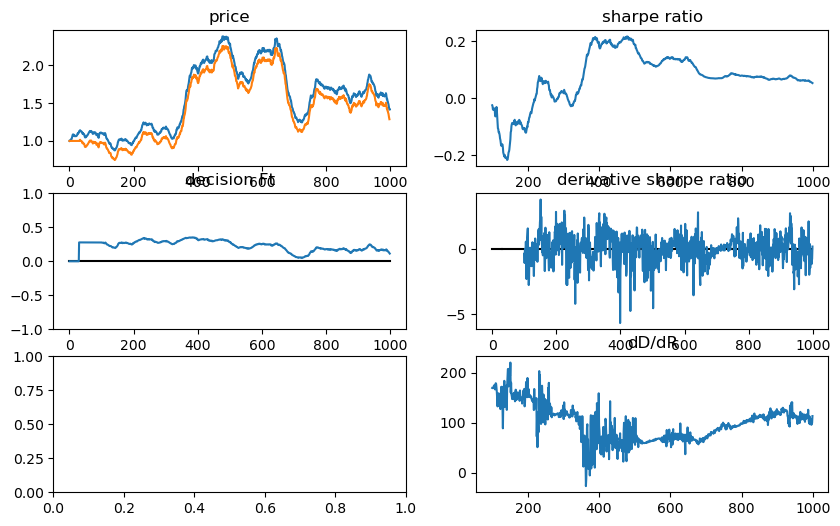

Episode:  3


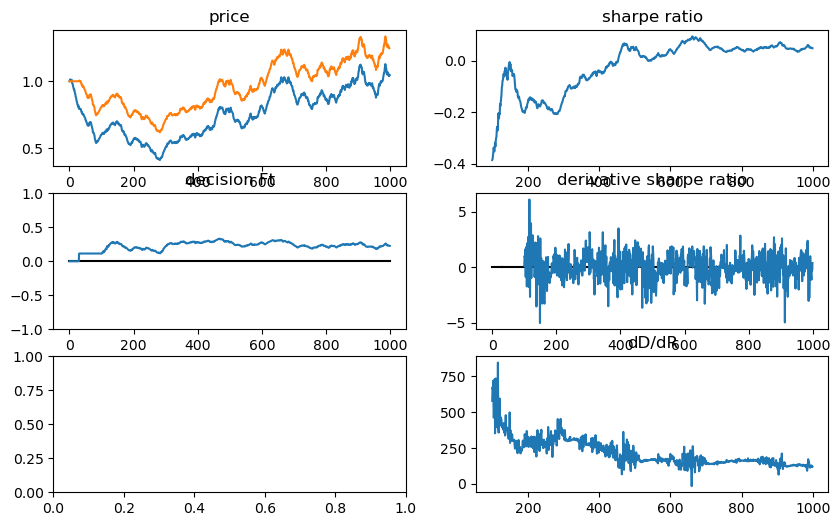

Episode:  4


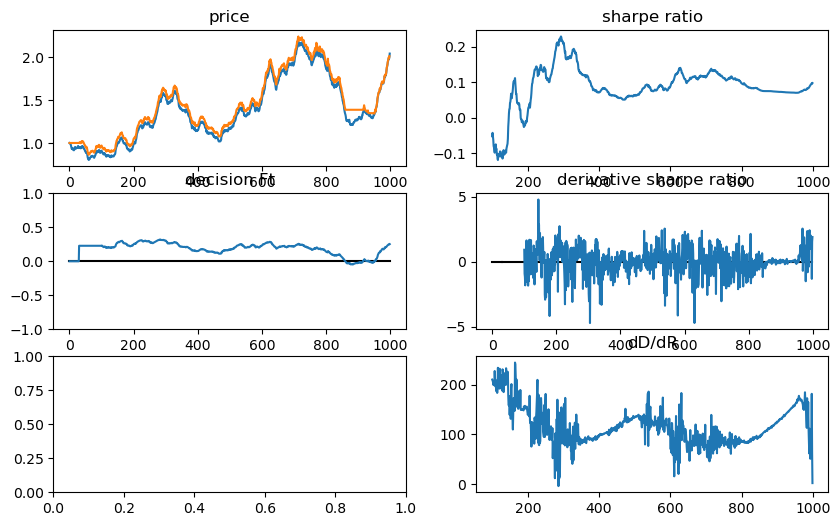

Episode:  5


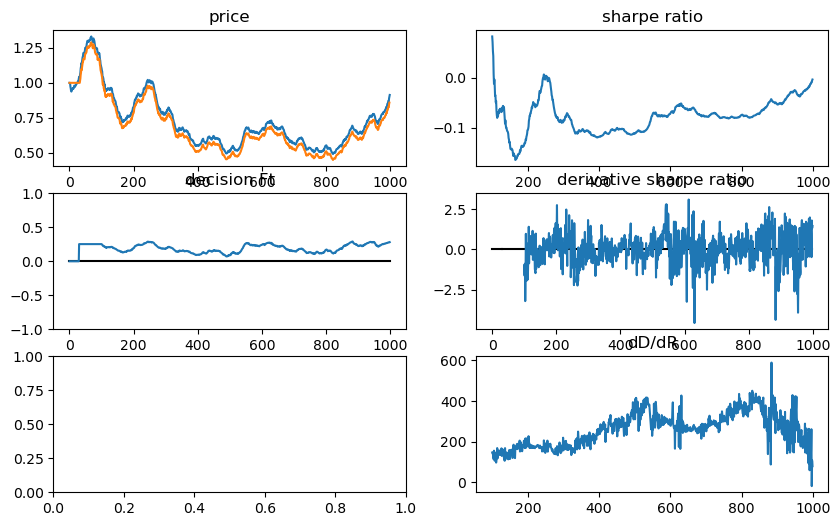

Episode:  6


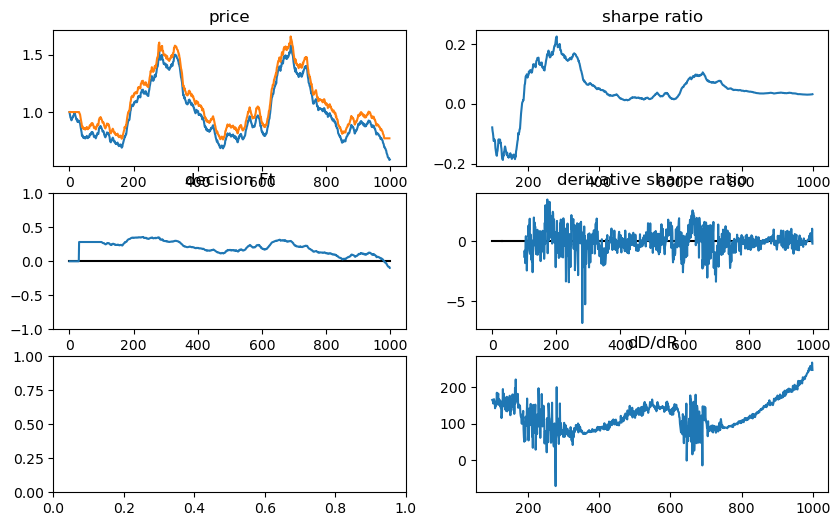

Episode:  7


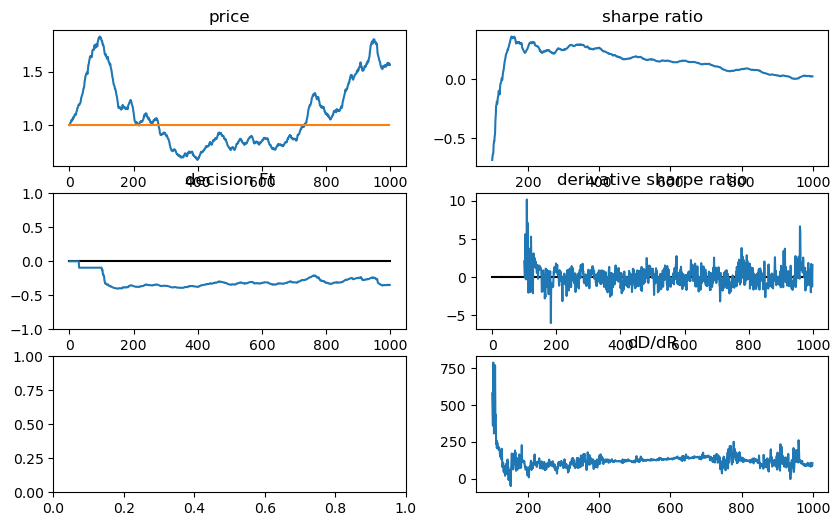

Episode:  8


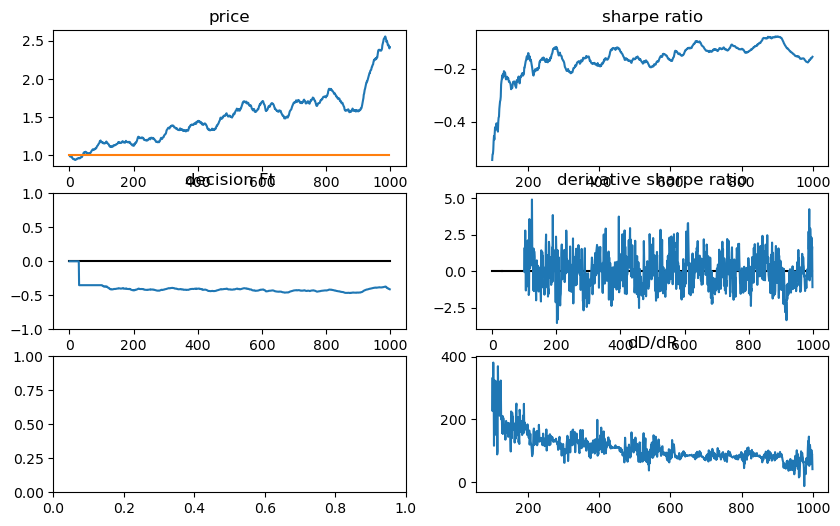

KeyboardInterrupt: 

In [6]:
import warnings
warnings.filterwarnings("ignore")

# GENERATION VARS
import time

MU = tf.constant(3.0)
N = tf.constant(0.01)
RISKFREE_RETURN = 0
TRANS_COST = 0.1
SERIES_LENGTH = 1000
TRADING_DELAY = 100
K = 3
A = 0.9

EPISODES = 100
INSTANCES = 1

BASELINE_SERIES = gen_price_series(size=SERIES_LENGTH, k=K, a=A, instances=INSTANCES)

for ep in range(EPISODES):

    # generate price series
    zt = gen_price_series(size=SERIES_LENGTH, k=K, a=A, instances=INSTANCES)
    rt = calc_price_returns(zt)
    Ft = np.zeros((INSTANCES, SERIES_LENGTH,), dtype=np.float32)

    # breaks if init at one; MUST INIT ZERO
    At = np.zeros((INSTANCES, SERIES_LENGTH,), dtype=np.float32)
    Bt = np.zeros((INSTANCES, SERIES_LENGTH,), dtype=np.float32)
    dF_dTheta_prev = None

    Rt_series = np.zeros((INSTANCES, SERIES_LENGTH,))
    SR_series = np.zeros((INSTANCES, SERIES_LENGTH,))
    DSR_series = np.zeros((INSTANCES, SERIES_LENGTH,))
    dD_series = np.ones((INSTANCES, SERIES_LENGTH,))
    autodiff_series = np.ones((INSTANCES, SERIES_LENGTH,))

    for t in range(INPUT_SIZE, SERIES_LENGTH): 
        Rt, Ft[:, t], At[:, t], Bt[:, t], dDt_dRt, dRt_dFcurr, dRt_dFprev, dF_dTheta = calc_grads(zt[:, t - INPUT_SIZE + 1:t + 1], rt[:, t], At[:, t-1], Bt[:, t-1], N, MU, F_model, tf.Variable(Ft[:, t-1]))

        '''DIAGNOSTICS. -----------------'''
        Rt_series[:, t] = Rt
        SR_series[:, t] = np.mean(Rt_series[:, INPUT_SIZE:t]) / np.std(Rt_series[:, INPUT_SIZE:t])
        DSR_series[:, t] = (Bt[:, t-1] * (Rt - At[:, t-1]) - (1/2) * (At[:, t-1] * (Rt ** 2 - Bt[:, t-1]))) / ((Bt[:, t-1] - At[:, t-1] ** 2) ** 1.5)
        dD_series[:, t] = dDt_dRt
        '''---------------------------------'''

        # need to continously update so that the first training step has a t-1 value.
        dF_dTheta_prev = dF_dTheta

        # dont update parameters if DSR hasn't stabilized yet
        if t < TRADING_DELAY:
            continue

        '''THIS BIT APPLIES THE GRADIENTS. --------------'''
        if t != INPUT_SIZE:
            # multiply derivatives together.
            gradient_update = []

            for i in range(len(dF_dTheta)):
                total_elements = prod(dF_dTheta[i].shape)

                # expand the "scalar" derivatives to the shape of the model variables. (jacobians)
                dDt_dRt_exp = reshape_grad(dDt_dRt, dF_dTheta[i].shape)
                dRt_dFcurr_exp = reshape_grad(dRt_dFcurr, dF_dTheta[i].shape)
                dRt_dFprev_exp = reshape_grad(dRt_dFprev, dF_dTheta[i].shape)

                grad = dDt_dRt_exp * (dRt_dFcurr_exp * dF_dTheta[i] + dRt_dFprev_exp * dF_dTheta_prev[i])
                grad = tf.reduce_sum(grad, axis=0)
                grad *= LEARNING_RATE / INSTANCES # divide by instances since the gradients are summed over all instances.

                # gradient_update.append(tf.reshape(grad, F_curr_model.trainable_variables[i].shape))
                gradient_update.append(grad)

            
            vars = F_model.trainable_variables
            for i in range(len(vars)):
                vars[i].assign_add(gradient_update[i])
            '''--------------------------------------------'''
        

    '''PLOT DIAGNOSTICS. -----------------'''
    if ep % 1 == 0: 
        print("Episode: ", ep)
        # test performance
        deltas, val_series = test_performance(zt, Ft)

        fig, ax = plt.subplots(3, 2, figsize=(10, 6))

        ax[0, 0].plot(zt[0])
        ax[0, 0].plot(val_series[0][0])
        ax[0, 0].set_title("price")

        ax[1, 0].plot(Ft[0] * 0, color='k')
        ax[1, 0].plot(Ft[0])
        ax[1, 0].set_ylim([-1, 1])
        ax[1, 0].set_title("decision Ft")

    
        SR_cut = SR_series.copy()
        SR_cut[:, :TRADING_DELAY] = np.nan
        ax[0, 1].plot(SR_cut[0])
        ax[0, 1].set_title("sharpe ratio")

        DSR_cut = DSR_series.copy()
        DSR_cut[:, :TRADING_DELAY] = np.nan
        ax[1, 1].plot(DSR_series[0] * 0, color='k')
        ax[1, 1].plot(DSR_cut[0])
        ax[1, 1].set_title("derivative sharpe ratio")

        dD_cut = dD_series.copy()
        dD_cut[:, :TRADING_DELAY] = np.nan
        ax[2, 1].plot(dD_cut[0])
        ax[2, 1].set_title("dD/dR")

        plt.show()
        plt.show()
    '''-----------------------------------'''

